      Date  Production
0  1962-01         589
1  1962-02         561
2  1962-03         640
3  1962-04         656
4  1962-05         727


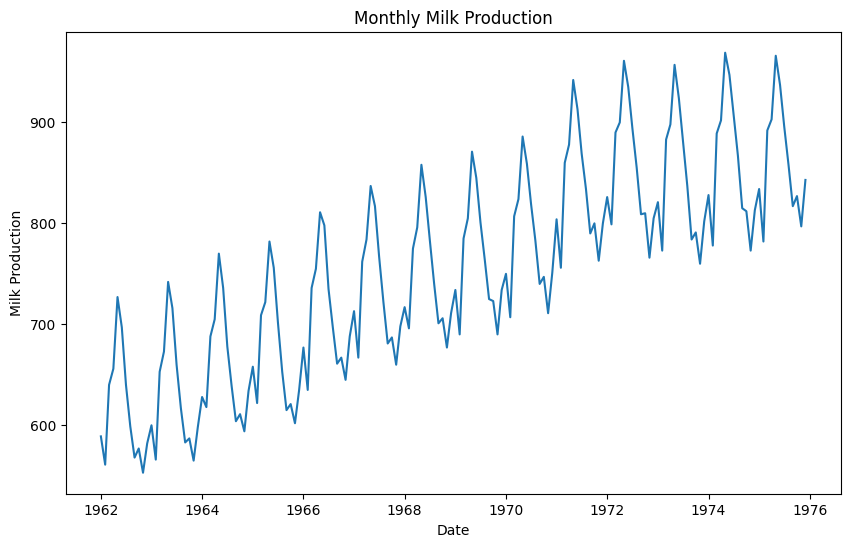

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('monthly_milk_production.csv')

# Display the first few rows of the dataset
print(data.head())

# Extract the relevant column (assuming production is the second column)
data['Date'] = pd.to_datetime(data['Date'])  # Convert date to datetime
data.set_index('Date', inplace=True)
milk_production = data['Production']

# Plot the data to visualize the trend
plt.figure(figsize=(10,6))
plt.plot(milk_production)
plt.title('Monthly Milk Production')
plt.xlabel('Date')
plt.ylabel('Milk Production')
plt.show()


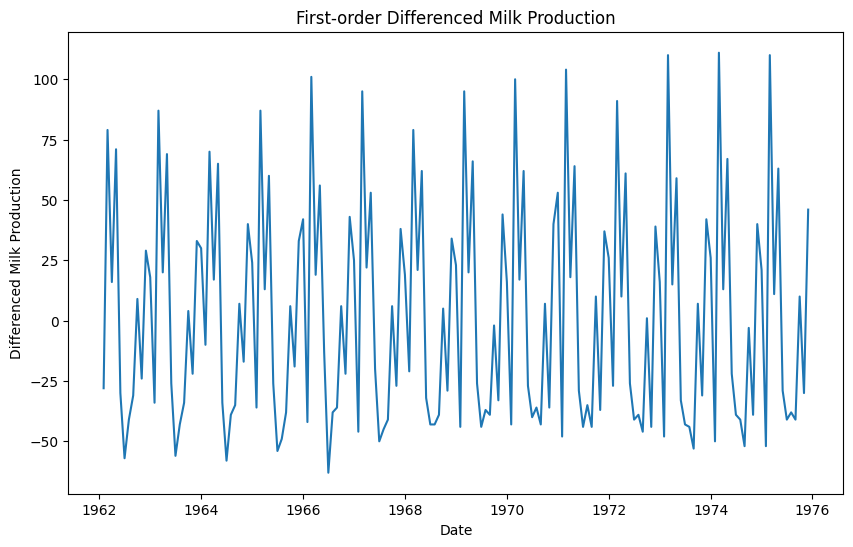

In [3]:
# First-order differencing
milk_production_diff = milk_production.diff().dropna()

# Plot the differenced data
plt.figure(figsize=(10,6))
plt.plot(milk_production_diff)
plt.title('First-order Differenced Milk Production')
plt.xlabel('Date')
plt.ylabel('Differenced Milk Production')
plt.show()


In [4]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Data preparation (same as before)
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    lstm_units_1 = trial.suggest_int('lstm_units_1', 10, 100)
    lstm_units_2 = trial.suggest_int('lstm_units_2', 10, 100)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    epochs = trial.suggest_int('epochs', 20, 100)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=lstm_units_1, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=lstm_units_2, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_test, y_test))

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_inverted = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate mean squared error (MSE) as the evaluation metric
    mse = mean_squared_error(y_test_inverted, y_pred_inverted)

    return mse

# Normalize the differenced data
scaler = MinMaxScaler(feature_range=(0, 1))
milk_production_diff_scaled = scaler.fit_transform(milk_production_diff.values.reshape(-1, 1))

# Define time steps (lag)
time_step = 12

# Create X (features) and y (target)
X, y = create_sequences(milk_production_diff_scaled, time_step)

# Reshape X to be in [samples, time steps, features] format, as required by LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create study and run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  # You can increase n_trials to explore more options

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)


[I 2024-10-19 19:50:16,106] A new study created in memory with name: no-name-6ca1c5f6-101b-4cee-a3be-7b88708dd628
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


[I 2024-10-19 19:50:41,044] Trial 0 finished with value: 3301.3089333207804 and parameters: {'lstm_units_1': 11, 'lstm_units_2': 73, 'batch_size': 128, 'learning_rate': 6.936084706772498e-05, 'epochs': 70}. Best is trial 0 with value: 3301.3089333207804.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


[I 2024-10-19 19:50:58,087] Trial 1 finished with value: 2770.2858292758283 and parameters: {'lstm_units_1': 33, 'lstm_units_2': 12, 'batch_size': 128, 'learning_rate': 0.0002715161591771036, 'epochs': 33}. Best is trial 1 with value: 2770.2858292758283.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


[I 2024-10-19 19:51:22,595] Trial 2 finished with value: 2105.061589207829 and parameters: {'lstm_units_1': 88, 'lstm_units_2': 92, 'batch_size': 128, 'learning_rate': 0.0006974766870321101, 'epochs': 65}. Best is trial 2 with value: 2105.061589207829.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


[I 2024-10-19 19:51:42,830] Trial 3 finished with value: 2265.7705002891685 and parameters: {'lstm_units_1': 43, 'lstm_units_2': 83, 'batch_size': 32, 'learning_rate': 8.24882994861734e-05, 'epochs': 40}. Best is trial 2 with value: 2105.061589207829.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


[I 2024-10-19 19:52:13,923] Trial 4 finished with value: 102.18259106597634 and parameters: {'lstm_units_1': 82, 'lstm_units_2': 39, 'batch_size': 32, 'learning_rate': 0.009309454796365494, 'epochs': 81}. Best is trial 4 with value: 102.18259106597634.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


[I 2024-10-19 19:52:48,761] Trial 5 finished with value: 2314.8106111547763 and parameters: {'lstm_units_1': 83, 'lstm_units_2': 56, 'batch_size': 32, 'learning_rate': 1.1208053569808806e-05, 'epochs': 90}. Best is trial 4 with value: 102.18259106597634.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


[I 2024-10-19 19:53:15,073] Trial 6 finished with value: 2108.5621376580293 and parameters: {'lstm_units_1': 61, 'lstm_units_2': 82, 'batch_size': 64, 'learning_rate': 0.00017324837487964106, 'epochs': 69}. Best is trial 4 with value: 102.18259106597634.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


[I 2024-10-19 19:53:37,835] Trial 7 finished with value: 5025.3934002974365 and parameters: {'lstm_units_1': 37, 'lstm_units_2': 20, 'batch_size': 64, 'learning_rate': 1.007342880346678e-05, 'epochs': 58}. Best is trial 4 with value: 102.18259106597634.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


[I 2024-10-19 19:54:04,475] Trial 8 finished with value: 2217.651313527549 and parameters: {'lstm_units_1': 94, 'lstm_units_2': 65, 'batch_size': 64, 'learning_rate': 3.9725684207492485e-05, 'epochs': 59}. Best is trial 4 with value: 102.18259106597634.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


[I 2024-10-19 19:54:25,039] Trial 9 finished with value: 666.1468536815795 and parameters: {'lstm_units_1': 86, 'lstm_units_2': 25, 'batch_size': 32, 'learning_rate': 0.0022994905158181065, 'epochs': 37}. Best is trial 4 with value: 102.18259106597634.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


[I 2024-10-19 19:55:00,460] Trial 10 finished with value: 267.4003017006359 and parameters: {'lstm_units_1': 67, 'lstm_units_2': 39, 'batch_size': 32, 'learning_rate': 0.00589213227118705, 'epochs': 98}. Best is trial 4 with value: 102.18259106597634.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


[I 2024-10-19 19:55:35,876] Trial 11 finished with value: 153.25663590615184 and parameters: {'lstm_units_1': 69, 'lstm_units_2': 38, 'batch_size': 32, 'learning_rate': 0.008073540813271149, 'epochs': 100}. Best is trial 4 with value: 102.18259106597634.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


[I 2024-10-19 19:56:06,345] Trial 12 finished with value: 82.96596280221483 and parameters: {'lstm_units_1': 71, 'lstm_units_2': 38, 'batch_size': 32, 'learning_rate': 0.009551891496666576, 'epochs': 84}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


[I 2024-10-19 19:56:37,389] Trial 13 finished with value: 371.1534190595386 and parameters: {'lstm_units_1': 72, 'lstm_units_2': 41, 'batch_size': 32, 'learning_rate': 0.0018698913827617967, 'epochs': 81}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step


[I 2024-10-19 19:57:07,297] Trial 14 finished with value: 323.81524625389414 and parameters: {'lstm_units_1': 49, 'lstm_units_2': 49, 'batch_size': 32, 'learning_rate': 0.0026069136742052587, 'epochs': 82}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step


[I 2024-10-19 19:57:36,249] Trial 15 finished with value: 521.099852846567 and parameters: {'lstm_units_1': 78, 'lstm_units_2': 31, 'batch_size': 32, 'learning_rate': 0.001012236703431883, 'epochs': 79}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


[I 2024-10-19 19:57:59,229] Trial 16 finished with value: 530.6372408635051 and parameters: {'lstm_units_1': 100, 'lstm_units_2': 54, 'batch_size': 32, 'learning_rate': 0.009030950727486813, 'epochs': 49}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


[I 2024-10-19 19:58:16,663] Trial 17 finished with value: 1122.8030690713886 and parameters: {'lstm_units_1': 56, 'lstm_units_2': 12, 'batch_size': 32, 'learning_rate': 0.003999296428064789, 'epochs': 23}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step


[I 2024-10-19 19:58:46,353] Trial 18 finished with value: 2047.5141355138353 and parameters: {'lstm_units_1': 77, 'lstm_units_2': 47, 'batch_size': 128, 'learning_rate': 0.0007173028355020527, 'epochs': 91}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step


[I 2024-10-19 19:59:12,872] Trial 19 finished with value: 843.5082584459043 and parameters: {'lstm_units_1': 22, 'lstm_units_2': 65, 'batch_size': 64, 'learning_rate': 0.0012384683421561775, 'epochs': 77}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


[I 2024-10-19 19:59:45,418] Trial 20 finished with value: 224.24902665401083 and parameters: {'lstm_units_1': 63, 'lstm_units_2': 25, 'batch_size': 32, 'learning_rate': 0.005101349688279571, 'epochs': 93}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


[I 2024-10-19 20:00:19,396] Trial 21 finished with value: 157.88710011793094 and parameters: {'lstm_units_1': 72, 'lstm_units_2': 37, 'batch_size': 32, 'learning_rate': 0.009705414963726908, 'epochs': 96}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step


[I 2024-10-19 20:00:53,790] Trial 22 finished with value: 310.1360381493117 and parameters: {'lstm_units_1': 54, 'lstm_units_2': 32, 'batch_size': 32, 'learning_rate': 0.0040722194011786955, 'epochs': 100}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


[I 2024-10-19 20:01:25,282] Trial 23 finished with value: 340.3338050107419 and parameters: {'lstm_units_1': 69, 'lstm_units_2': 46, 'batch_size': 32, 'learning_rate': 0.009462245976663789, 'epochs': 86}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


[I 2024-10-19 20:01:59,699] Trial 24 finished with value: 162.63020885746138 and parameters: {'lstm_units_1': 80, 'lstm_units_2': 58, 'batch_size': 32, 'learning_rate': 0.005521686658379368, 'epochs': 87}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step


[I 2024-10-19 20:02:30,431] Trial 25 finished with value: 369.42562261754 and parameters: {'lstm_units_1': 92, 'lstm_units_2': 34, 'batch_size': 32, 'learning_rate': 0.0031061139669438073, 'epochs': 74}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


[I 2024-10-19 20:03:01,868] Trial 26 finished with value: 335.22776266113675 and parameters: {'lstm_units_1': 59, 'lstm_units_2': 25, 'batch_size': 32, 'learning_rate': 0.0015350507285819494, 'epochs': 85}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


[I 2024-10-19 20:03:25,011] Trial 27 finished with value: 991.767854114395 and parameters: {'lstm_units_1': 48, 'lstm_units_2': 44, 'batch_size': 32, 'learning_rate': 0.0004656341156883997, 'epochs': 53}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


[I 2024-10-19 20:03:56,372] Trial 28 finished with value: 313.98006636976544 and parameters: {'lstm_units_1': 76, 'lstm_units_2': 19, 'batch_size': 64, 'learning_rate': 0.006785306478138664, 'epochs': 100}. Best is trial 12 with value: 82.96596280221483.
C:\Users\aditya\AppData\Local\Temp\ipykernel_9224\2917127733.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


[I 2024-10-19 20:04:20,836] Trial 29 finished with value: 919.0632217731339 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 66, 'batch_size': 128, 'learning_rate': 0.0032640274013100976, 'epochs': 71}. Best is trial 12 with value: 82.96596280221483.


Best hyperparameters: {'lstm_units_1': 71, 'lstm_units_2': 38, 'batch_size': 32, 'learning_rate': 0.009551891496666576, 'epochs': 84}


C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - loss: 0.1236 - val_loss: 0.0790
Epoch 2/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0707 - val_loss: 0.0763
Epoch 3/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0736 - val_loss: 0.0744
Epoch 4/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0688 - val_loss: 0.0735
Epoch 5/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0632 - val_loss: 0.0745
Epoch 6/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0632 - val_loss: 0.0710
Epoch 7/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0674 - val_loss: 0.0718
Epoch 8/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0598 - val_loss: 0.0683
Epoch 9/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0642 - val_loss: 0.0595
Epoch 10/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0489 - val_loss: 0.1087
Epoch 11/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0694 - val_loss: 0.0551
Epoch 12/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0560 - val_loss: 0.0689

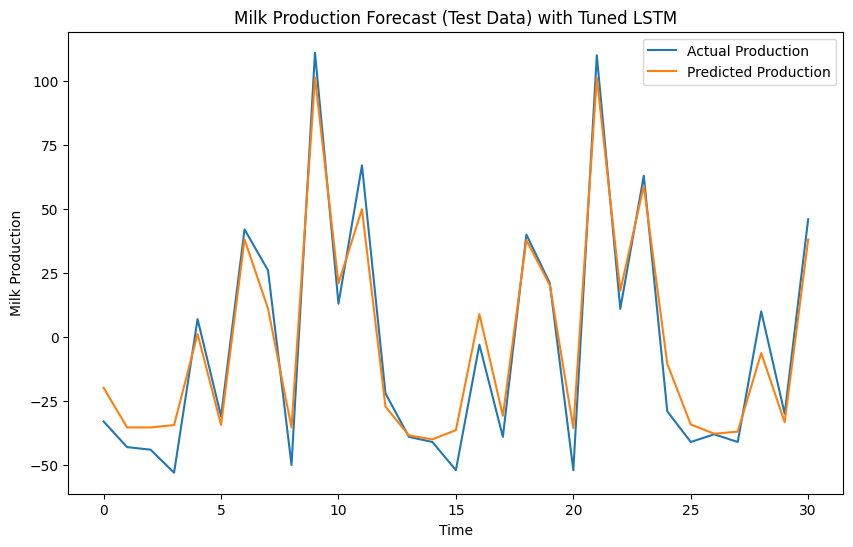

In [5]:
# Build the model with the best hyperparameters
best_params = study.best_params
lstm_units_1 = best_params['lstm_units_1']
lstm_units_2 = best_params['lstm_units_2']
batch_size = best_params['batch_size']
learning_rate = best_params['learning_rate']
epochs = best_params['epochs']

# Rebuild and train the model with the best hyperparameters
model = Sequential()
model.add(LSTM(units=lstm_units_1, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=lstm_units_2, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

# Train the model with the best parameters
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)
y_pred_inverted = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs predicted results
plt.figure(figsize=(10,6))
plt.plot(y_test_inverted, label='Actual Production')
plt.plot(y_pred_inverted, label='Predicted Production')
plt.title('Milk Production Forecast (Test Data) with Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Milk Production')
plt.legend()
plt.show()


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Inverted predictions and actual values
y_pred_inverted = scaler.inverse_transform(y_pred.reshape(-1, 1))  # Already predicted values from test data
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))  # Actual test data

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverted, y_pred_inverted)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverted, y_pred_inverted)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 104.76464356504896
Root Mean Squared Error (RMSE): 10.235460105195514
Mean Absolute Error (MAE): 8.527778214023959


Epoch 1/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 2/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 3/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 4/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 5/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 6/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 7/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 9/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 10/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 11/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 12/84
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0043 - val_loss: 0.0029
E

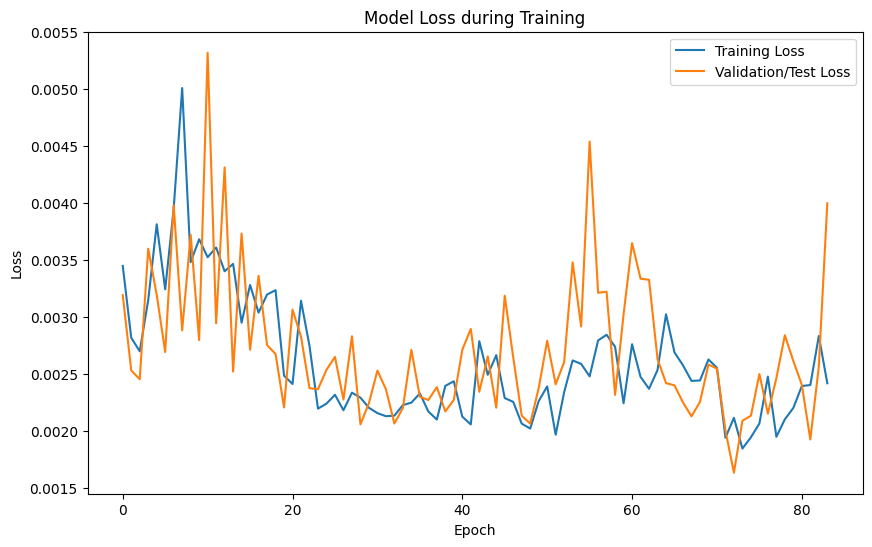

In [7]:
import matplotlib.pyplot as plt

# Assuming you are using 'history' from model.fit()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_test, y_test), verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
# Predictions on training data
y_train_pred = model.predict(X_train)
y_train_pred_inverted = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_train_inverted = scaler.inverse_transform(y_train.reshape(-1, 1))

# Predictions on test data (already done as y_pred_inverted and y_test_inverted)

# Calculate error metrics for training set
train_mse = mean_squared_error(y_train_inverted, y_train_pred_inverted)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_inverted, y_train_pred_inverted)

# Calculate error metrics for test set (already done previously)
test_mse = mean_squared_error(y_test_inverted, y_pred_inverted)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_inverted, y_pred_inverted)

# Print training vs test metrics
print(f'Training MSE: {train_mse}, RMSE: {train_rmse}, MAE: {train_mae}')
print(f'Test MSE: {test_mse}, RMSE: {test_rmse}, MAE: {test_mae}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Training MSE: 73.84970189102481, RMSE: 8.59358492661967, MAE: 5.941406623009713
Test MSE: 104.76464356504896, RMSE: 10.235460105195514, MAE: 8.527778214023959


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Implement EarlyStopping with patience set to 5 or 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=76, restore_best_weights=True)

# Re-train the model with early stopping
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=100, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0019 - val_l

In [12]:
# Retrain the model for 75 epochs
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=75, 
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 2/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 3/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 5/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 6/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 11/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 12/75
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0013 - val_loss: 0.0020
E

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predictions on the test set
y_test_pred = model.predict(X_test)

# Invert scaling for both predictions and actual values
y_test_pred_inverted = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE, RMSE, and MAE on the test set
test_mse = mean_squared_error(y_test_inverted, y_test_pred_inverted)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_inverted, y_test_pred_inverted)

# Print the evaluation metrics
print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Test MSE: 96.26526067277169
Test RMSE: 9.811486160249714
Test MAE: 7.739187698210439


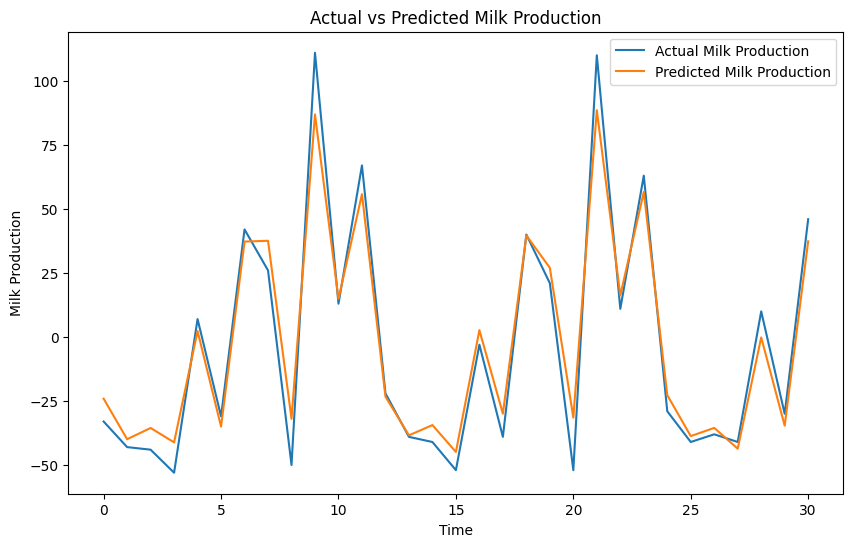

In [14]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_inverted, label='Actual Milk Production')
plt.plot(y_test_pred_inverted, label='Predicted Milk Production')
plt.title('Actual vs Predicted Milk Production')
plt.xlabel('Time')
plt.ylabel('Milk Production')
plt.legend()
plt.show()
